# 专题：支持向量机

支持向量机（support vector machine，SVM）是非常强大、灵活的有监督学习算法，既可用于分类，也可用于回归。在本节中，我们将介绍支持向量机的原理，并用它解决分类问题。首先还是导入需要用的程序库：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

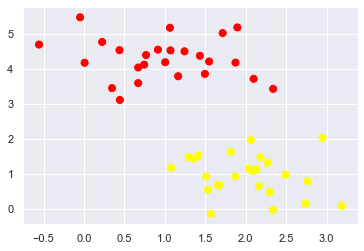

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

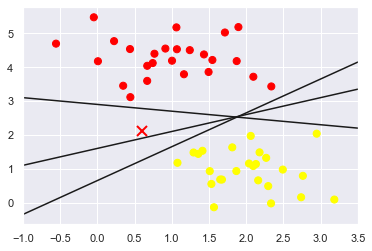

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

# 支持向量机：边界最大化

支持向量机提供了改进这个问题的方法，它直观的解释是：不再画一条细线来区分类型，而是画一条到最近点边界、有宽度的线条。

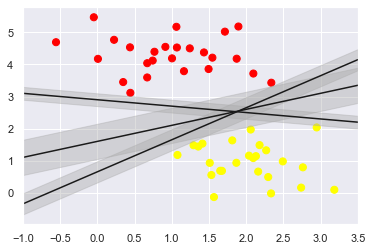

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

**1. 拟合支持向量机**

来看看这个数据的真实拟合结果：用Scikit-Learn 的支持向量机分类器在数据上训练一个SVM 模型。这里用一个线性核函数，并将参数C 设置为一个很大的数（后面会介绍这些设置的意义）

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """画二维SVC的决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 画决策边界和边界
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=1, facecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

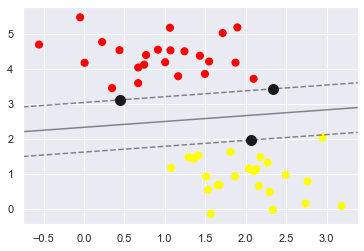

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [20]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

分类器能够成功拟合的关键因素，就是这些支持向量的位置——任何在正确分类一侧远离边界线的点都不会影响拟合结果！从技术角度解释的话，是因为这些点不会对拟合模型的损失函数产生任何影响，所以只要它们没有跨越边界线，它们的位置和数量就都无关紧要。

例如，可以分别画出数据集前60 个点和前120 个点的拟合结果，并进行对比

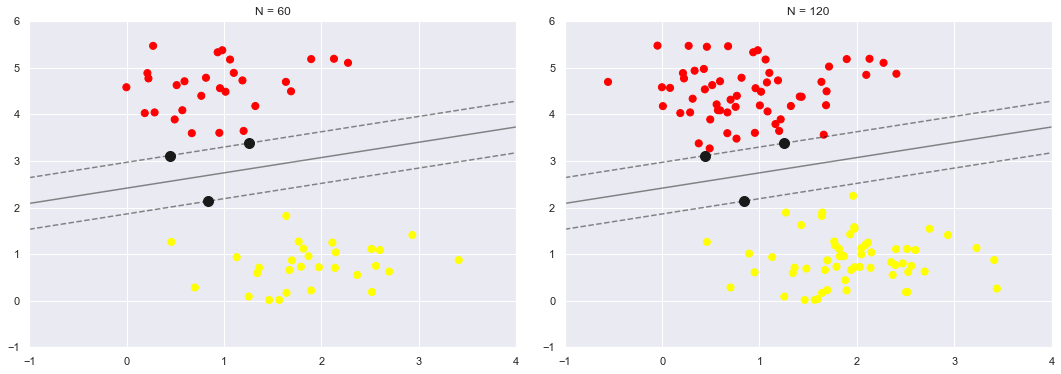

In [21]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

我们在左图中看到的是前60个训练样本的模型和支持向量。在右图中，虽然我们画了前120 个训练样本的支持向量，但是模型并没有改变：左图中的3个支持向量仍然适用于右图。这种对远离边界的数据点不敏感的特点正是SVM 模型的优点之一。

In [25]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,20,60,100,200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 60, 100, 200), value=10), Output()), _dom_cla…

**2. 超越线性边界：核函数SVM模型**

将SVM 模型与核函数组合使用，功能会非常强大。那时，我们将数据投影到多项式和高斯基函数定义的高维空间中，从而实现用线性分类器拟合非线性关系

在SVM 模型中，我们可以沿用同样的思路。为了应用核函数，引入一些非线性可分的数据

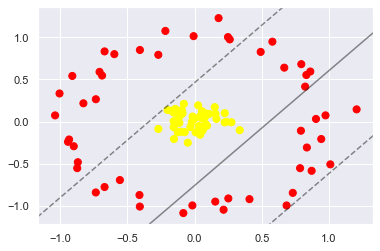

In [28]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

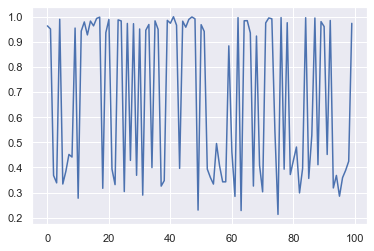

In [29]:
r = np.exp(-(X ** 2).sum(1))
plt.plot(r)

In [33]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azim=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

在Scikit-Learn 里面，我们可以应用核函数化的SVM 模型将线性核转变为RBF（径向基函数）核，设置kernel模型超参数即可.

In [34]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

E:\python\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

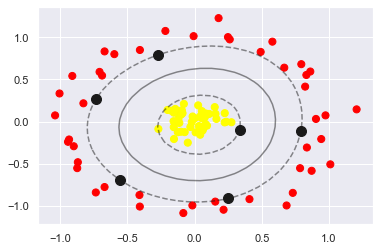

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
#plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
#            s=300, lw=1, facecolors='none');

通过使用这个核函数化的支持向量机，我们找到了一条合适的非线性决策边界。在机器学习中，核变换策略经常用于将快速线性方法变换成快速非线性方法，尤其是对于那些可以应用核函数技巧的模型.

**3. SVM优化：软化边界**

到目前为止，我们介绍的模型都是在处理非常干净的数据集，里面都有非常完美的决策边界。但如果你的数据有一些重叠该怎么办呢？例如，有如下所示一些数据

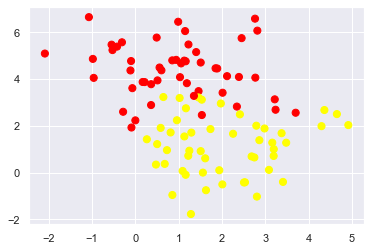

In [40]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

为了解决这个问题，SVM 实现了一些修正因子来“软化”边界。为了取得更好的拟合效果，它允许一些点位于边界线之内。边界线的硬度可以通过超参数进行控制，通常是C。

如果C 很大，边界就会很硬，数据点便不能在边界内“生存”；如果C比较小，边界线比较软，有一些数据点就可以穿越边界线。

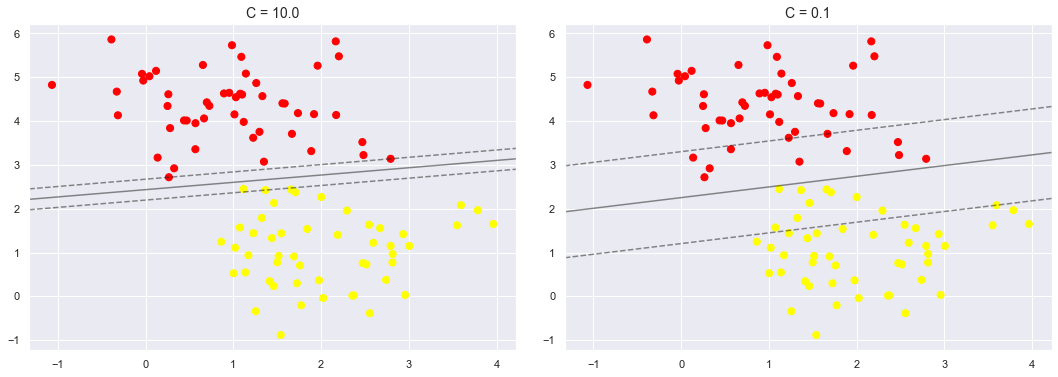

In [43]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi,False)
#     axi.scatter(model.support_vectors_[:, 0],
#                 model.support_vectors_[:, 1],
#                 s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# 案例：人脸识别

我们用人脸识别案例来演示支持向量机的实战过程。这里用Wild 数据集中带标记的人脸图像，里面包含了数千张公开的人脸照片。Scikit-Learn 内置了获取照片数据集的功能:

In [44]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


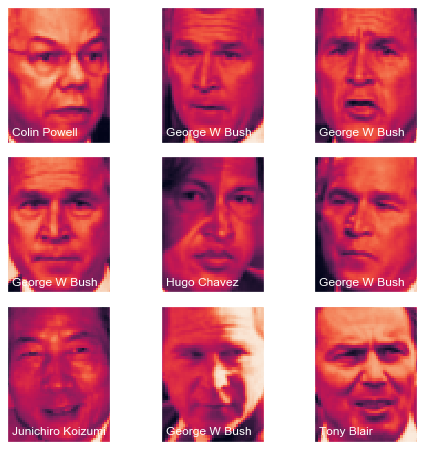

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i])#, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, faces.target_names[faces.target[i]],
            transform=ax.transAxes, color='white',fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

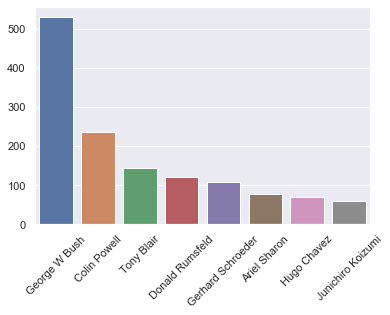

In [63]:
# 照片数量分布
import pandas as pd
num=pd.Series(faces.target).apply(lambda x:faces.target_names[x]).value_counts()
sns.barplot(x=num.index,y=num)
plt.xticks(rotation=45)

每个图像包含[62×47]、接近3000 像素。虽然可以简单地将每个像素作为一个特征，但是更高效的方法通常是使用预处理器来提取更有意义的特征。这里使用主成分分析来提取150 个基本元素，然后将其提供给支持向量机分类器。可以将这个预处理器和分类器打包成管道：

In [65]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

为了测试分类器的训练效果，将数据集分解成训练集和测试集进行交叉检验：

In [66]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

最后，用网格搜索交叉检验来寻找最优参数组合。通过不断调整参数C（控制边界线的硬度）和参数gamma（控制径向基函数核的大小），确定最优模型：

In [68]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

E:\python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 24.7 s
{'svc__C': 10, 'svc__gamma': 0.001}


In [69]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

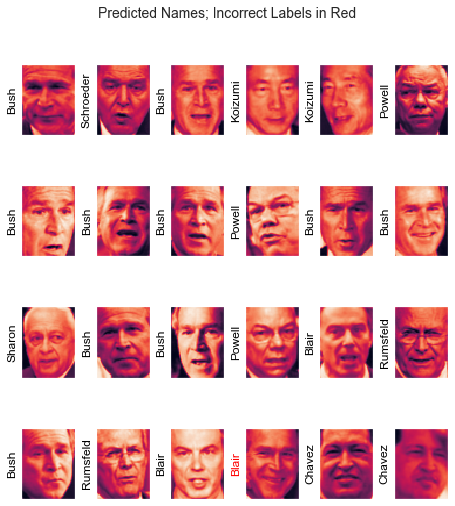

In [77]:
fig, axes = plt.subplots(4, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.7, wspace=0.01))
for i, axi in enumerate(axes.flat):
    axi.imshow(Xtest[i].reshape(62, 47))#, cmap='bone')
    #axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [78]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



(8, 0)

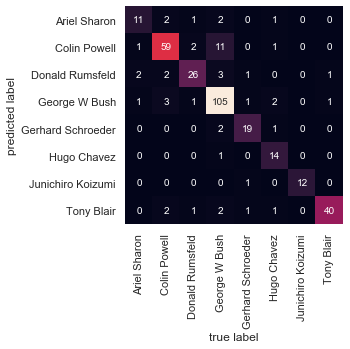

In [81]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.ylim([8,0])

真实环境中的人脸识别问题的照片通常不会被切割得这么整齐（即使像素相同），两类人脸分类机制的唯一差别其实是特征选择：你需要用更复杂的算法找到人脸，然后提取图片中与像素化无关的人脸特征。这类问题有一个不错的解决方案，就是用 OpenCV（http://opencv.org) 配合其他手段，包括最先进的通用图像和人脸图像的特征提取工具，来获取人脸特征数据。

In [83]:
# 流形算法
# 流形学习算法中的Isomap算法对数据进行降维
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(faces.data)
data_projected = iso.transform(faces.data)
data_projected.shape

(1348, 2)

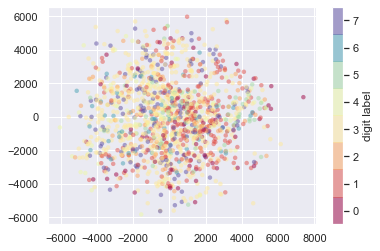

In [84]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=faces.target, s=20,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 8))
plt.colorbar(label='digit label', ticks=range(8))
plt.clim(-0.5, 7.5)

上述流形算法将图像数据压缩到2个维度时，图像之间的区分度很差，说明图像识别需要的主成分要远大于2个维度